# This notebook shows how to load the pre-computed stimulus analyses from the h5 file.

Stimulus analyses are packaged using h5 files and the `h5py` Python library. The groups in the file are organized according to the `mouse --> column/volume --> plane --> stimulus` heirarchy. An example screenshot of a plane group is shown below.

Each group has various attributes that describe the data. For example, the plane group has attributes describing the mouse id, number of ROIs, depth, etc.

Inside the plane groups are groups for each stimulus analysis, along with other important data for the plane, including SSI metrics, pika classification scores, etc.

Inside the column/volume group, there is also information on duplicate ROIs detected by trace correlations and image mask overlap, but this is also stored in individual planes.

**If you use VSCode as an IDE, I recommend getting the `H5Web` extension to intuitively view these h5 files!**

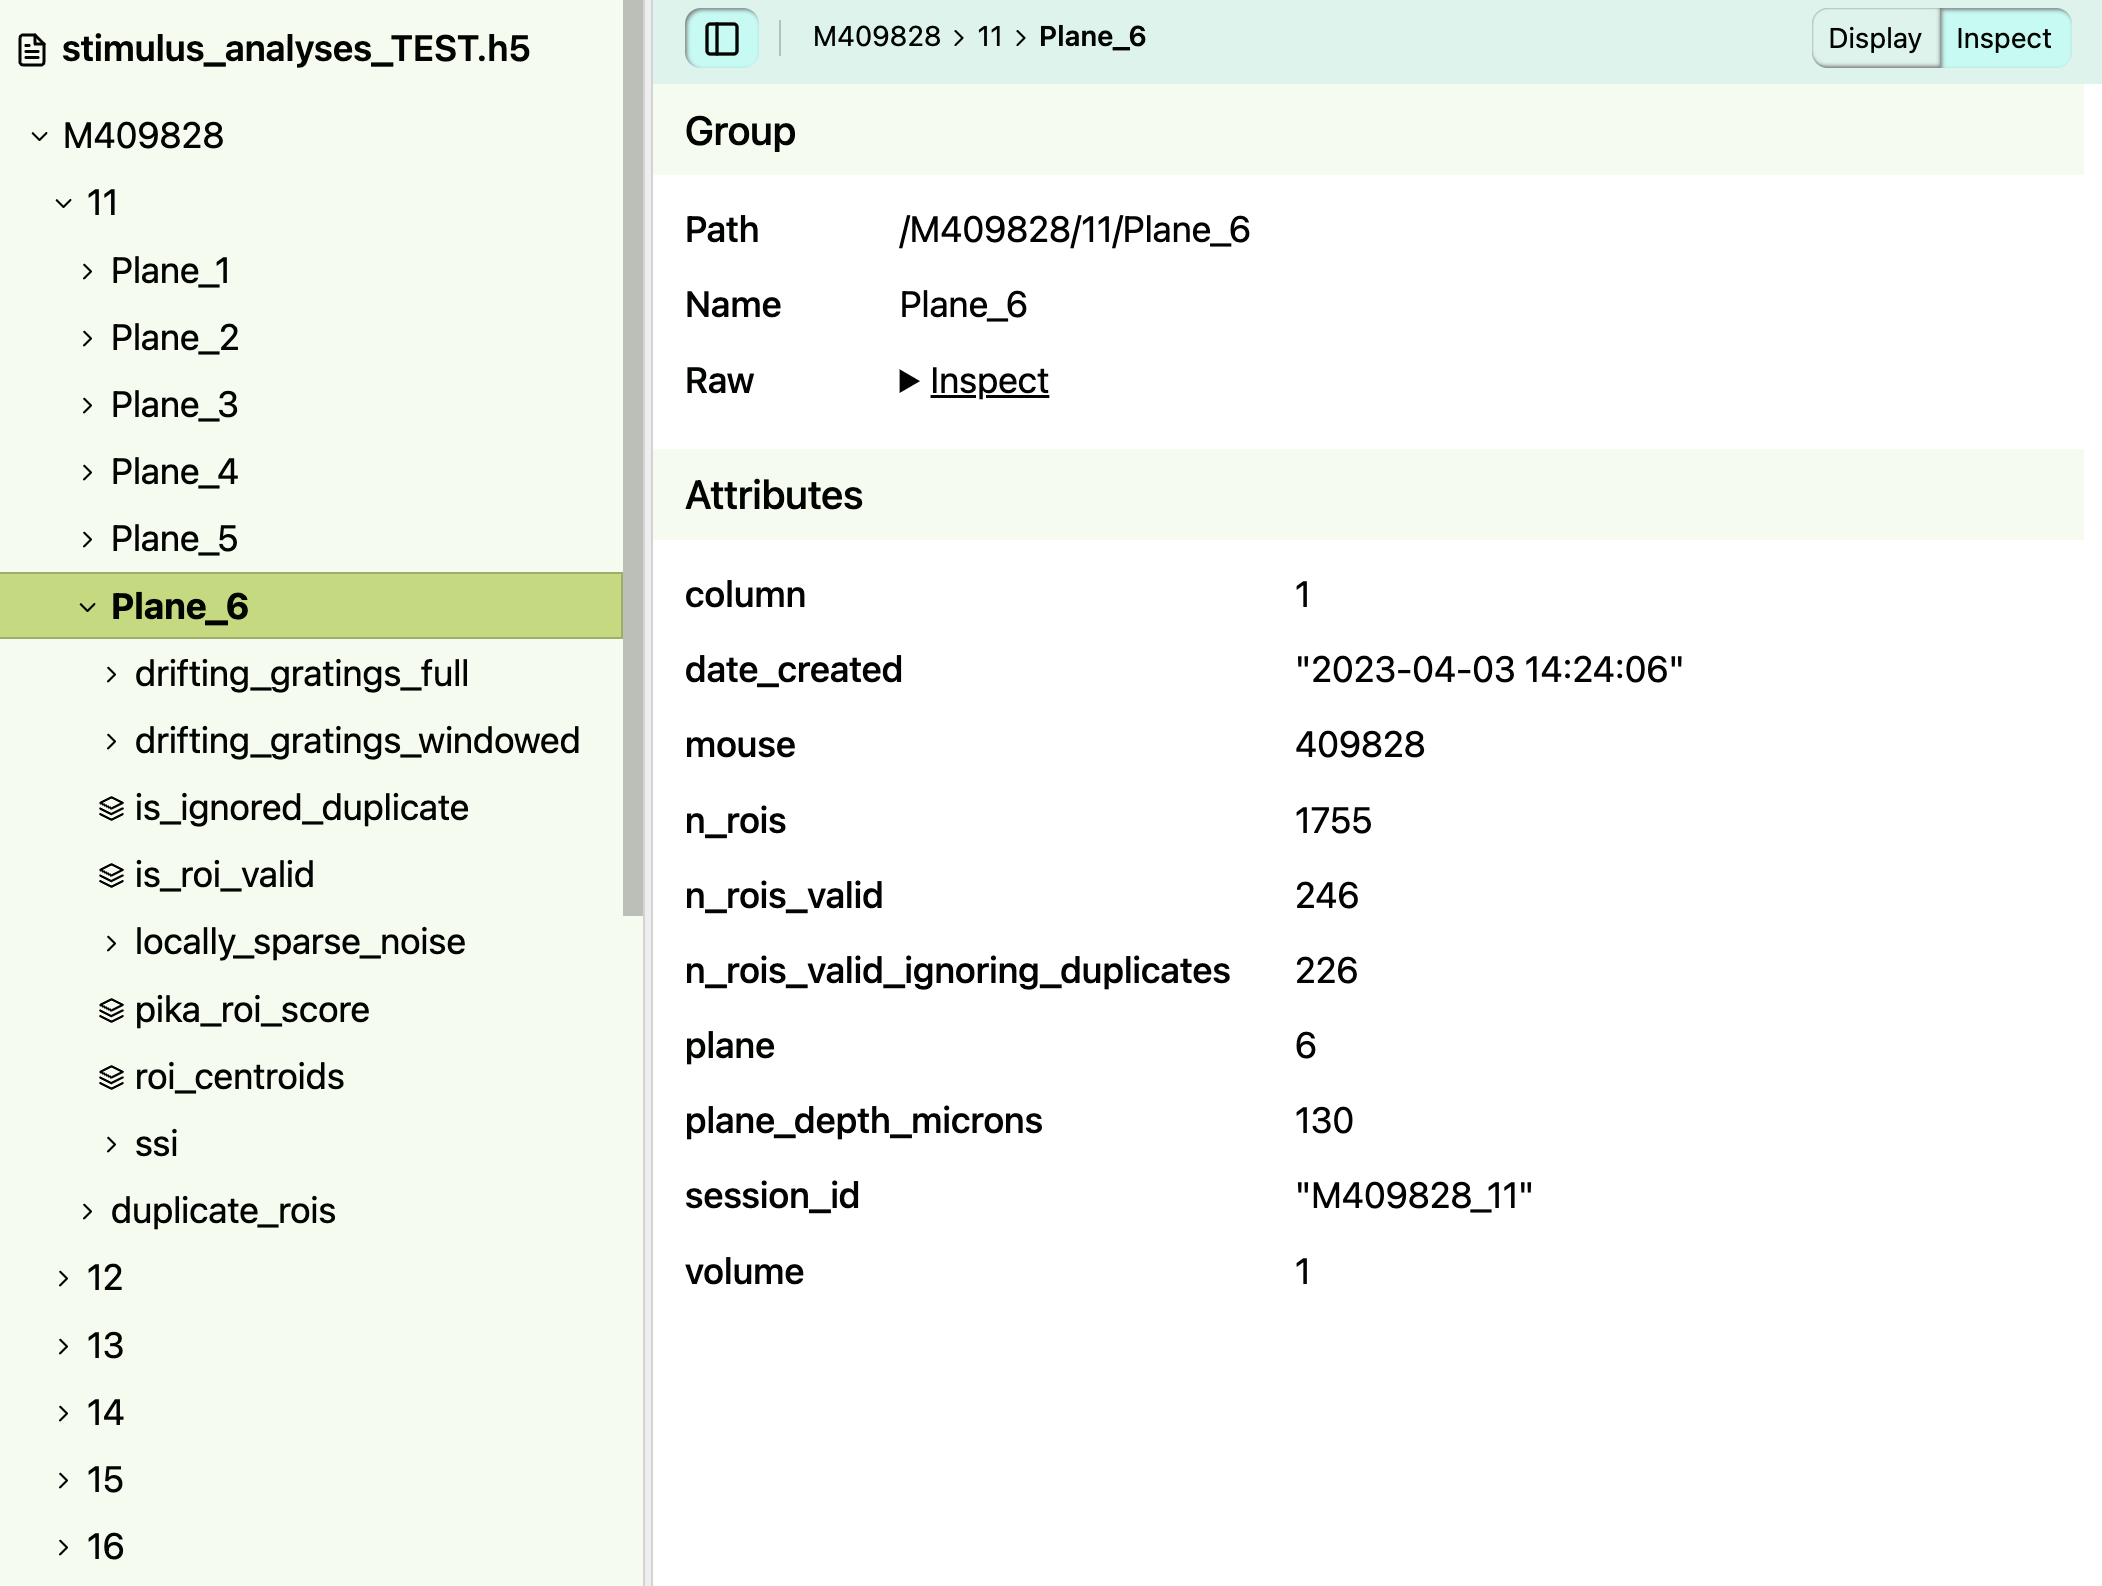

In [1]:
# <!-- ![example-h5-file-structure]() -->
from IPython.display import Image
Image(filename="../assets/ex-stim-analysis.png", width=1000)

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

import allen_v1dd.stimulus_analysis.analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups

at.set_stylesheet()

%load_ext autoreload
%autoreload 2

Set the location of the h5 analysis file

The isilon file path is
```
/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data/stimulus_analyses/stimulus_analyses_v[LATEST_VERSION].h5
```

See `stim_analysis_changelogs.md` for complete version changelogs.

In [3]:
# Path to stimulus analysis file
at.set_analysis_file(r"/Users/chase/Desktop/stimulus_analyses_v1.h5")

In [4]:
# This is what the analysis_tools.iter_plane_groups method does.
# It is very useful for iterating over all analysis objects
iter_plane_groups?

Signature: iter_plane_groups(filename: str = None)
Docstring:
Iterate all plane groups in an h5 analysis file

Args:
    filename (str, optional): Filename for h5 analysis file. Defaults to the filename set using set_analysis_file.

Raises:
    ValueError: If no analysis file is supplied

Yields:
    h5 group: All plane groups in analysis file
File:      ~/Desktop/MindScope/allen_v1dd/src/allen_v1dd/stimulus_analysis/analysis_tools.py
Type:      function

There are also useful methods for restricting analyses to certain mice and columns.

In [5]:
# Set list of included mice ids
# at.set_included_mice([409828])
at.set_included_mice(None) # all

# Set list of included column ids
# at.set_included_columns([1])
at.set_included_columns([2, 3, 4, 5])

# Count unique ROIs across all mice

In [6]:
at.set_included_columns([2, 3, 4, 5])
unique_roi_count_by_mouse = {}

for group in iter_plane_groups():
    mouse = group.attrs["mouse"]
    is_valid = group["is_roi_valid"][()]
    is_ignored_duplicate = group["is_ignored_duplicate"][()]
    n_unique = np.count_nonzero(is_valid & ~is_ignored_duplicate)

    unique_roi_count_by_mouse[mouse] = unique_roi_count_by_mouse.get(mouse, 0) + n_unique

unique_roi_count_by_mouse

{409828: 18065, 416296: 15322, 427836: 15190, 438833: 14899}

# Plot ROI centroids

In [7]:
for group in iter_plane_groups():
    session = group.attrs["session_id"]
    plane = group.attrs["plane"]

    if plane == 6: # In shallow volumes and low planes only a few ROIs are present (e.g., 11 plane 1)
        fig, ax = plt.subplots(figsize=(6, 6))

        valid_roi_centroids = group["roi_centroids"][group["is_roi_valid"][()]]
        ax.scatter(valid_roi_centroids[:, 0], valid_roi_centroids[:, 1], s=25, color="black")
        ax.axis("equal")
        ax.invert_yaxis()
        ax.set_xlabel("Column (pixels)")
        ax.set_ylabel("Row (pixels)")
        ax.set_title(f"{session}, Plane {plane} Valid ROIs (n = {len(valid_roi_centroids)})")
        break

# Basic example: Count valid ROIs by depth (ignoring duplicates)
We have reason to believe the ROI matching algorithm picks up the same ROI in multiple planes at a rate that could significantly alter statistics computed across the entire dataset. Thus we **strongly recommend** filtering out ROIs where `group["is_ignored_duplicate"]` is true. An example is provided below:

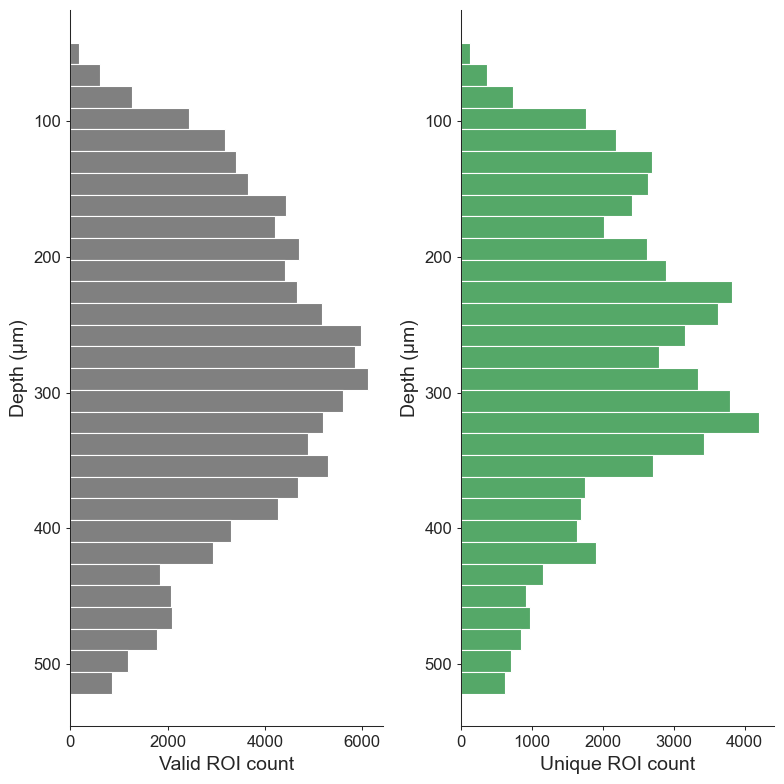

In [8]:
roi_counts_at_depth = {}
roi_counts_ignore_duplicates_at_depth = {}

for group in iter_plane_groups():
    depth = group.attrs["plane_depth_microns"]
    is_valid = group["is_roi_valid"][()] # binary vector, size n_rois
    is_ignored_duplicate = group["is_ignored_duplicate"][()] # binary vector, size n_rois
    n_valid_rois = group.attrs["n_rois_valid"]
    n_non_dup_rois = np.count_nonzero(is_valid & ~is_ignored_duplicate)
    roi_counts_at_depth[depth] = roi_counts_at_depth.get(depth, 0) + n_valid_rois
    roi_counts_ignore_duplicates_at_depth[depth] = roi_counts_ignore_duplicates_at_depth.get(depth, 0) + n_non_dup_rois

fig, axs = plt.subplots(figsize=(8, 8), ncols=2)
axs[0].barh(list(roi_counts_at_depth.keys()), list(roi_counts_at_depth.values()), height=16, color="gray") # 16 micron plane depth
for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel("Depth (µm)")
axs[0].set_xlabel("Valid ROI count")
axs[1].barh(list(roi_counts_ignore_duplicates_at_depth.keys()), list(roi_counts_ignore_duplicates_at_depth.values()), height=16, color="g") # 16 micron plane depth
axs[1].set_xlabel("Unique ROI count")
# plt.setp(axs, xlim=(0, max(ax.get_xlim()[1] for ax in axs))) # Same x-scale
fig.tight_layout()
fig.savefig("/Users/chase/Desktop/roi_count.png", dpi=150)

# Stim responsiveness

In [9]:
stim_resp_count = {}
total_roi_count = 0

for group in iter_plane_groups():
    is_valid = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    total_roi_count += np.count_nonzero(is_valid)
    
    for stim_name in group.keys():
        stim_group = group[stim_name]

        if stim_name == "locally_sparse_noise":
            resp_vec = stim_group["is_responsive"][is_valid, 2] # has any RF
        elif "drifting_gratings" in stim_name:
            resp_vec = stim_group["is_responsive"][is_valid]
        else: continue

        stim_resp_count[stim_name] = stim_resp_count.get(stim_name, 0) + np.count_nonzero(resp_vec)

for stim, count in stim_resp_count.items():
    print(f"{stim}: {count:,} / {total_roi_count:,} ({count/total_roi_count*100:.1f}%)")

drifting_gratings_full: 14,847 / 63,476 (23.4%)
drifting_gratings_windowed: 17,816 / 63,476 (28.1%)
locally_sparse_noise: 17,003 / 63,476 (26.8%)


# DGW metrics by depth

In [10]:
dg_metrics = pd.DataFrame(columns=["depth", "osi", "dsi", "pref_dir"], dtype=float)

for group in iter_plane_groups():
    depth = group.attrs["plane_depth_microns"]
    valid_rois = np.where(group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()])[0]
    dgw = group["drifting_gratings_windowed"]

    for roi in valid_rois:
        if dgw["is_responsive"][roi]:
            dg_metrics.loc[len(dg_metrics)] = (depth, dgw["osi"][roi], dgw["dsi"][roi], dgw["pref_cond"][roi][0])

dg_metrics.head()

,depth,osi,dsi,pref_dir
0,50.0,0.287317,0.473136,60.0
1,50.0,0.428314,0.171647,90.0
2,50.0,0.421001,0.301746,240.0
3,50.0,0.231562,0.193348,0.0
4,66.0,0.918117,0.907317,60.0


<Axes: xlabel='dsi', ylabel='depth'>

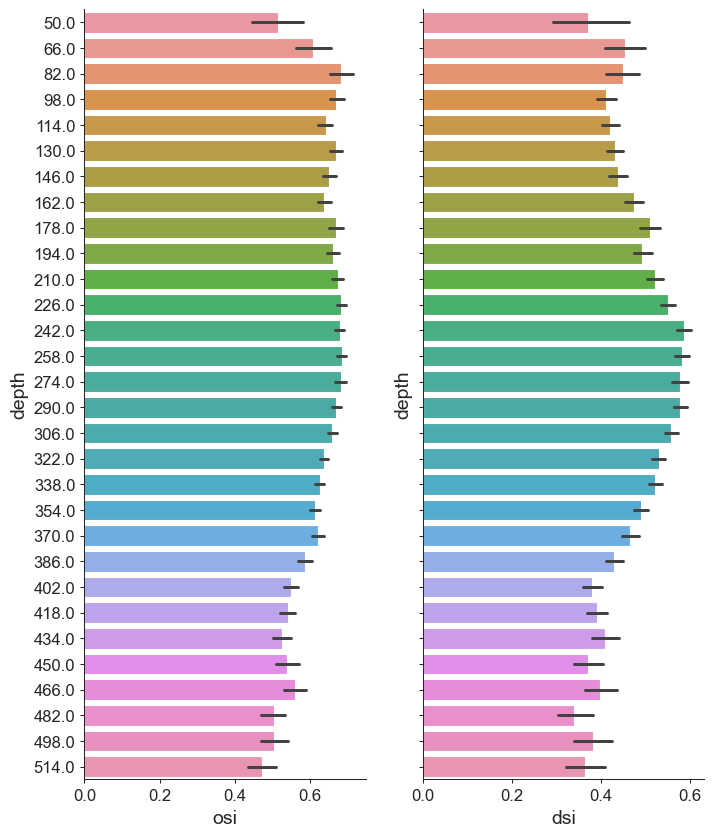

In [11]:
fig, axs = plt.subplots(figsize=(8, 10), ncols=2, sharey=True)

sns.barplot(data=dg_metrics, y="depth", x="osi", orient="h", ax=axs[0])
sns.barplot(data=dg_metrics, y="depth", x="dsi", orient="h", ax=axs[1])

# DGW preferred direction

<Axes: xlabel='pref_dir', ylabel='count'>

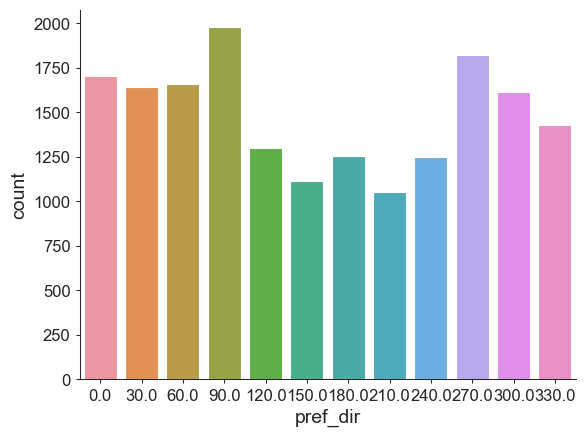

In [12]:
sns.countplot(data=dg_metrics, x="pref_dir")

# DGW trial responses

The drifting grating trial responses are stored in the `trial_responses` array which has shape `(n_rois, 12, 2, 8) = (n_rois, n_dirs, n_temp_freqs, n_trials)`. If you prefer working with the `xarray` format where these have proper index labels, I have this method to load the data:

In [13]:
from allen_v1dd.stimulus_analysis.drifting_gratings import load_dg_xarray_from_h5 # Converts ndarray to xarray

load_dg_xarray_from_h5?

Signature: load_dg_xarray_from_h5(group, key)
Docstring:
Loads a drifting grating xarray from an h5 group.

Args:
    group (hdf5 file group): Either a DGW or DGF group in the hdf5 file
    key (str): Key of array in group (e.g., "trial_responses")

Returns:
    xarray.DataArray: xarray with labeled dimensions
File:      ~/Desktop/MindScope/allen_v1dd/src/allen_v1dd/stimulus_analysis/drifting_gratings.py
Type:      function

Now let's just load a single session to show as an example

In [14]:
for group in iter_plane_groups():
    # Load a particular session
    if group.attrs["mouse"] != 409828 or group.attrs["plane"] != 0: continue

    dg_group = group["drifting_gratings_windowed"]
    dg_trial_responses = load_dg_xarray_from_h5(dg_group, "trial_responses")
    break # Just load one session

# Display out the xarray as an example
dg_trial_responses

<xarray.DataArray (roi: 3178, direction: 12, spatial_frequency: 2, trial: 8)>
array([[[[0.0042572 , 0.0035592 , 0.        , ..., 0.00302795,
          0.00641171, 0.00309188],
         [0.00616476, 0.0043269 , 0.        , ..., 0.00269149,
          0.00576832, 0.        ]],

        [[0.00343271, 0.00320986, 0.        , ..., 0.        ,
          0.00421517, 0.00900292],
         [0.        , 0.        , 0.00564561, ..., 0.00525262,
          0.00354109, 0.00328704]],

        [[0.0050861 , 0.        , 0.        , ..., 0.00771171,
                 nan,        nan],
         [0.00538109, 0.0033928 , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        ...,

        [[0.00452337, 0.00277823, 0.        , ..., 0.00321758,
          0.00497394, 0.0046846 ],
         [0.00349545, 0.        , 0.00283561, ..., 0.00300857,
...
                 nan,        nan],
         [0.        , 0.        , 0.01256798, ..., 0.02913352,
          0.0235762 , 0.        ]],

        ...,

        [[0.01720459, 0.        , 0.        , ..., 0.        ,
          0.        , 0.01297629],
         [0.03128478, 0.02013087, 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.02109775, 0.        , 0.        , ..., 0.02936199,
          0.        ,        nan],
         [0.02285053, 0.        , 0.        , ..., 0.        ,
          0.02273368, 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.02609736,
                 nan,        nan],
         [0.01574508, 0.01741358, 0.        , ..., 0.        ,
          0.01330528,        nan]]]])
Coordinates:
  * roi                (roi) int64 0 1 2 3 4 5 ... 3172 3173 3174 3175 3176 3177
  * direction          (direction) int64 0 30 60 90 120 ... 210 240 270 300 330
  * spatial_frequency  (spatial_frequency) float64 0.04 0.08
  * trial              (trial) int64 0 1 2 3 4 5 6 7

Just an example of what we'll be doing in the next snippet: 

In [15]:
dg_mean_trial_resp = dg_trial_responses.mean(dim="trial", skipna=True) # Trial-mean responses for each ROI
argmax_dims = ("direction", "spatial_frequency")
argmax_dict = dg_mean_trial_resp.argmax(dim=argmax_dims) # { dim: array of argmax for each ROI }
print("argmax_dict:")
print(argmax_dict)
print()
print("Example argmax for ROI = 6:")
argmax_dict["direction"][6].item(), argmax_dict["spatial_frequency"][6].item() # Call .item() to convert to int because otherwise the scalar value is returned as an xarray

argmax_dict:
{'direction': <xarray.DataArray (roi: 3178)>
array([ 2,  3, 11, ...,  3, 11,  3])
Coordinates:
  * roi      (roi) int64 0 1 2 3 4 5 6 7 ... 3171 3172 3173 3174 3175 3176 3177, 'spatial_frequency': <xarray.DataArray (roi: 3178)>
array([0, 0, 0, ..., 0, 0, 0])
Coordinates:
  * roi      (roi) int64 0 1 2 3 4 5 6 7 ... 3171 3172 3173 3174 3175 3176 3177}

Example argmax for ROI = 6:


(8, 0)

Now load across all planes. In a future version I'll have all the "argmax" junk packaged into the h5 file but for now we just have to compute it ourselves (essentially for every ROI, we find which preferred direction and spatial frequency combination maximizes the trial-averaged response):

In [16]:
dg_type = "windowed" # or "full"
mean_trial_responses = []
mean_blank_responses = []

for group in iter_plane_groups(): # Iterate over all sessions/planes
    dg_group = group[f"drifting_gratings_{dg_type}"]
    is_dg_responsive = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()] & dg_group["is_responsive"][()]
    # Note that the is_valid check is redundant because currently if an ROI is not valid it won't be flagged as DG-responsive

    # An alternate example if you want to be more lenient with DG inclusion
    is_dg_responsive = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()] & (dg_group["frac_responsive_trials"][()] >= 0.25)

    dg_trial_responses = load_dg_xarray_from_h5(dg_group, "trial_responses")
    dg_blank_responses = load_dg_xarray_from_h5(dg_group, "blank_responses")
    
    # Maybe our goal is to load the mean trial response = mean response in preferred condition
    # To do this we need to load the mean trial responses for each condition, and find the preferred condition for each responsive ROI

    # Trial-mean responses for each ROI
    dg_mean_trial_resp = dg_trial_responses.mean(dim="trial", skipna=True) # dims = ("roi", "direction", "spatial_frequency")
    
    # Find preferred conditions
    argmax_dims = ("direction", "spatial_frequency") # The dimensions we care about
    argmax_dict = dg_mean_trial_resp.fillna(-1).argmax(dim=argmax_dims) # fill na values to -1 to prevent error (na values are ignored in the is_responsive check later)

    for roi in range(group.attrs["n_rois"]):
        if is_dg_responsive[roi]: # Check if responsive based on our criteria
            # Find the ROI's preferred condition index (e.g., {"direction": 0, "spatial_frequency": 1})
            roi_argmaxs = {
                dim: argmax_arr[roi]
                for dim, argmax_arr in argmax_dict.items()
            }

            # Now find the mean trial response at this condition
            # Some xarray syntax here... I suggest looking up the xarray documentation if this is unfamiliar to you
            roi_pref_resp = (
                dg_mean_trial_resp.sel(roi=roi) # We can use the "sel" method to select based on index
                .isel(roi_argmaxs) # isel is used as an index selector (as opposed to coordinate). E.g. would .sel(direction=30) but .isel(direction=1)
                .item() # convert to scalar type (otherwise it stays as singleton dgarray)
            )

            mean_trial_responses.append(roi_pref_resp)

            # Also save the ROI's mean blank response (blank response = 2s gray screen stimulus interleaved with DG stimuli)
            mean_blank_responses.append(dg_blank_responses.sel(roi=roi).mean().item())

mean_trial_responses = np.array(mean_trial_responses)
mean_blank_responses = np.array(mean_blank_responses)

print(f"Loaded {len(mean_trial_responses)} mean trial responses")

Loaded 45359 mean trial responses


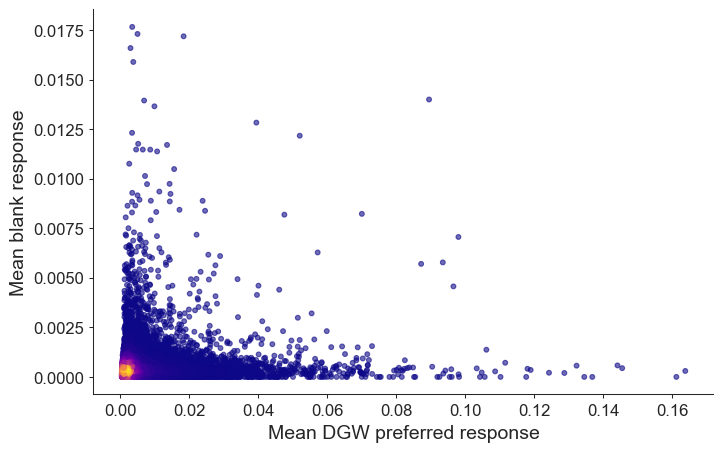

In [17]:
# This takes a while...
ax = at.density_scatter(
    x=mean_trial_responses,
    y=mean_blank_responses,
    xlabel="Mean DGW preferred response",
    ylabel="Mean blank response"
)
# ax.axis("equal")

Text(0, 0.5, 'ROI count')

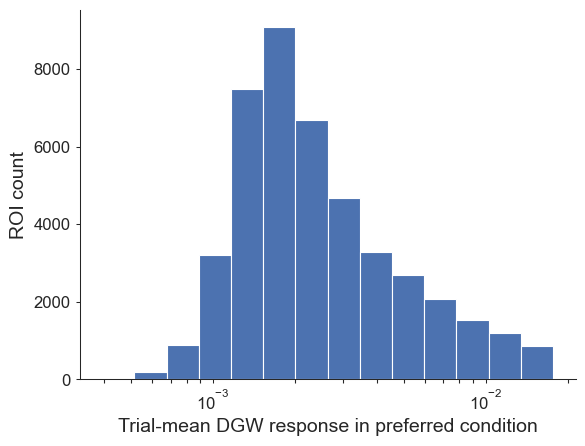

In [18]:
# Histogram of mean response
nbins = 15
logbins = np.geomspace(mean_trial_responses.min(), mean_blank_responses.max(), nbins)
plt.hist(mean_trial_responses, bins=logbins)
plt.xscale("log")
plt.xlabel("Trial-mean DGW response in preferred condition")
plt.ylabel("ROI count")

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_20961/2818972661.py:4: RuntimeWarning: divide by zero encountered in divide
  x = mean_trial_responses / mean_blank_responses


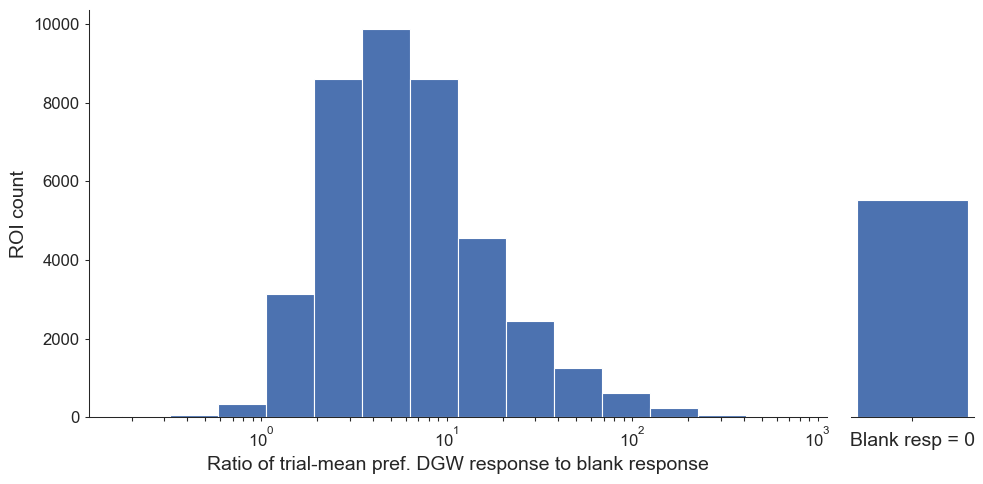

In [19]:
# Histogram of ratio of responses
fig, axs = plt.subplots(figsize=(10, 5), ncols=2, width_ratios=[6, 1], sharey=True)

x = mean_trial_responses / mean_blank_responses

# Left subplot: data where this is well-defined
ax = axs[0]
x_finite = x[np.isfinite(x)]
nbins = 15
logbins = np.geomspace(x_finite.min(), x_finite.max(), nbins)
ax.hist(x_finite, bins=logbins)
ax.set_xscale("log")
ax.set_xlabel("Ratio of trial-mean pref. DGW response to blank response")
ax.set_ylabel("ROI count")

# Right subplot: data where this is ill-defined (i.e., blank response = 0)
ax = axs[1]
ax.bar(x=[""], height=[np.count_nonzero(~np.isfinite(x))])
ax.set_xlabel("Blank resp = 0")
ax.get_yaxis().set_visible(False)
ax.spines["left"].set_visible(False)

fig.tight_layout()

# SSI metrics
I have created a lot of different SSI metrics. All of them are stored in the `ssi` group of a plane. To view what each one computes, check out the `"desc"` attribute.

In [20]:
ssi_dists = {}
ssi_names = {
    "ssi": "SSI",
    "ssi_running": "SSI (Running)",
    "ssi_stationary": "SSI (Stationary)"
}

for group in iter_plane_groups():
    is_responsive = ~group["is_ignored_duplicate"][()] & group["drifting_gratings_windowed"]["is_responsive"][()]
    ssi_group = group["ssi"]

    for metric in ssi_group.keys():
        values = ssi_group[metric][is_responsive]
        if metric not in ssi_dists:
            ssi_dists[metric] = []
            print(f"{metric}: {ssi_group[metric].attrs['desc']}")
        ssi_dists[metric].extend(values)

ssi: Computed from pref DGW condition and DGF response at that condition
ssi_avg: Computed from average DGW and DGF responses (across direction and spatial freq.)
ssi_avg_at_pref_sf: Computed from average DGW and DGF responses (across direction at preferred DGW spatial freq.)
ssi_running: Same as SSI, but while mouse is running (>1 cm/s). Must have at least 3 running trials in DGW and DGF.
ssi_running_avg_at_pref_sf: Computed from average DGW and DGF responses while mouse is running (>1 cm/s) (across direction at preferred DGW spatial freq.)
ssi_stationary: Same as SSI, but while mouse is stationary (<1 cm/s). Must have at least 3 stationary trials in DGW and DGF.
ssi_stationary_avg_at_pref_sf: Computed from average DGW and DGF responses while mouse is stationary (<1 cm/s) (across direction at preferred DGW spatial freq.)
ssi_tuning_fit: Computed from tuning curve fits. Uses DGW pref sf and corresponding tuning fit pref. dir. Then uses DGF tuning fit at that pref sf and dir.


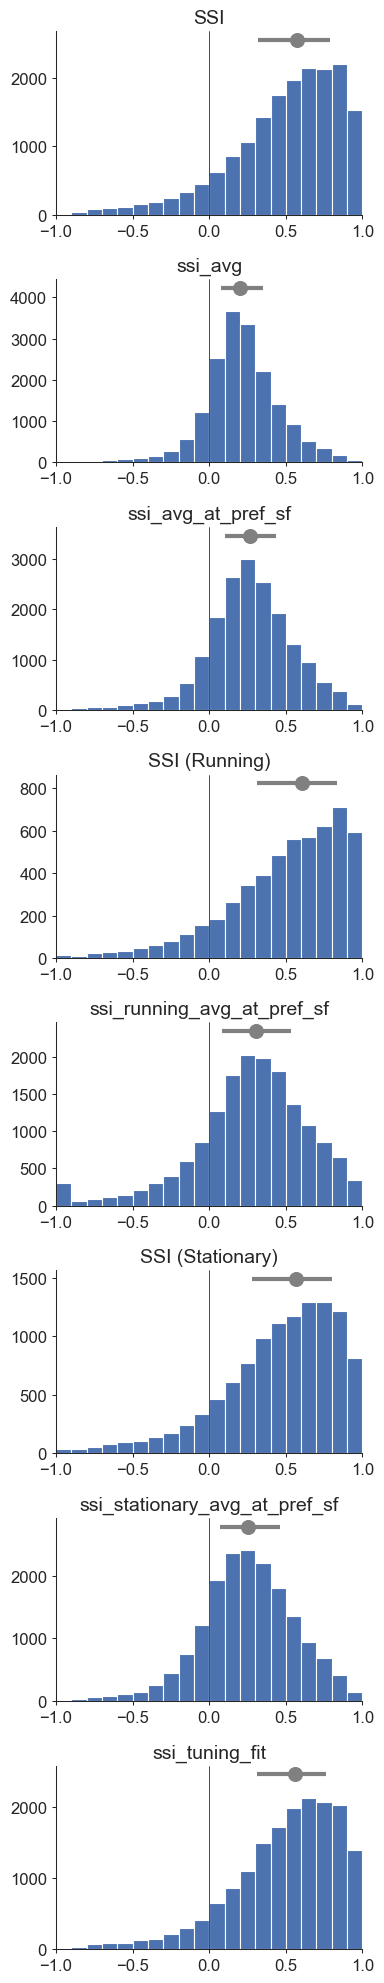

In [21]:
fig, axs = plt.subplots(figsize=(4, 2.5*len(ssi_dists)), nrows=len(ssi_dists))
bins = np.arange(-1, 1.1, 0.1)

for ax, (metric, values) in zip(axs, ssi_dists.items()):
    ax.set_title(ssi_names.get(metric, metric))
    ax.hist(values, bins)
    ax.axvline(x=0, color="black", linewidth=0.5)

    p25, p50, p75 = np.nanquantile(values, [0.25, 0.5, 0.75])
    y = ax.get_ylim()[1] * 1.1
    ax.scatter(p50, y, color="gray", s=100, zorder=10)
    ax.hlines(xmin=p25, xmax=p75, y=y, color="gray", linewidth=3)
    ax.set_xlim(-1, 1)

fig.tight_layout()
# fig.savefig("/Users/chase/Desktop/ssi_all_dists.png", dpi=200)

# SSI by depth

In [22]:
# DGW metrics by depth
ssi_keys = list(ssi_dists.keys())
ssi_metrics = pd.DataFrame(columns=["depth", *ssi_keys], dtype=float)

for group in iter_plane_groups():
    depth = group.attrs["plane_depth_microns"]
    rois = np.where(~group["is_ignored_duplicate"][()] & group["drifting_gratings_windowed"]["is_responsive"][()])[0]
    ssi_group = group["ssi"]

    for roi in rois:
        row = [depth]
        for ssi in ssi_keys:
            row.append(ssi_group[ssi][roi])
        ssi_metrics.loc[len(ssi_metrics)] = row

ssi_metrics

,depth,ssi,ssi_avg,ssi_avg_at_pref_sf,ssi_running,ssi_running_avg_at_pref_sf,ssi_stationary,ssi_stationary_avg_at_pref_sf,ssi_tuning_fit
0,50.0,0.169997,0.178505,0.138997,0.714269,0.338794,NaN,-0.222836,0.225284
1,50.0,0.315031,0.090188,0.069426,0.456289,0.154399,0.13102,-0.082297,0.107733
2,50.0,-0.409028,0.004834,-0.051058,-0.309935,0.069911,NaN,-0.273103,-0.338469
3,50.0,0.108027,-0.002924,-0.075151,0.245621,0.054254,NaN,-0.298160,0.227626
4,66.0,0.706099,0.001945,0.148136,0.811738,0.235176,NaN,-0.621441,0.818045
...,...,...,...,...,...,...,...,...,...
17811,514.0,0.430677,0.292792,0.298418,0.402510,0.358368,NaN,0.191620,0.409074
17812,514.0,0.278774,0.187031,0.368729,0.306428,0.432106,NaN,1.000000,0.305821
17813,514.0,0.383818,0.184068,0.114838,0.278912,0.134695,NaN,1.000000,0.079633
17814,514.0,0.167566,0.228892,0.132515,0.177100,0.238948,NaN,1.000000,0.142517


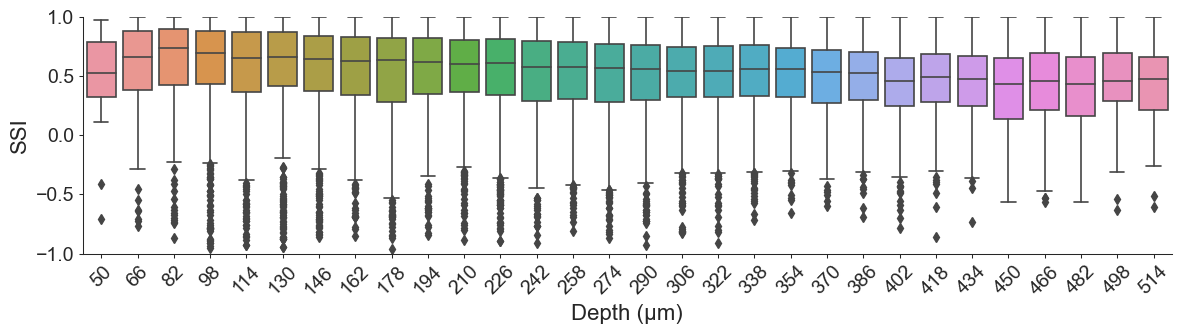

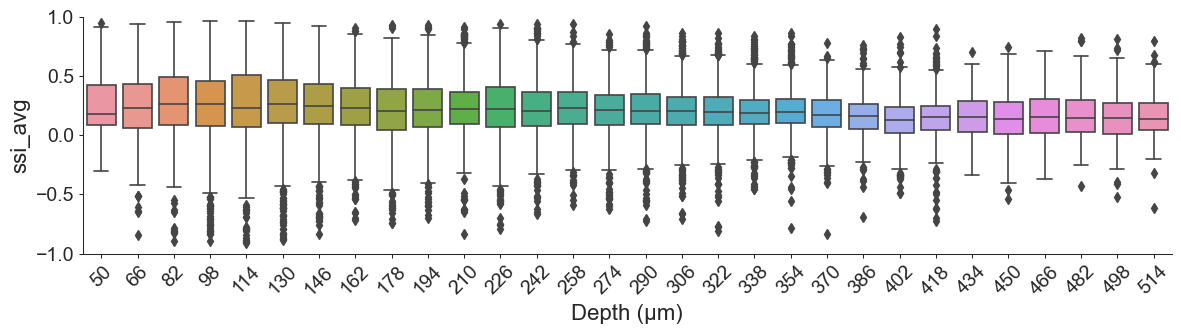

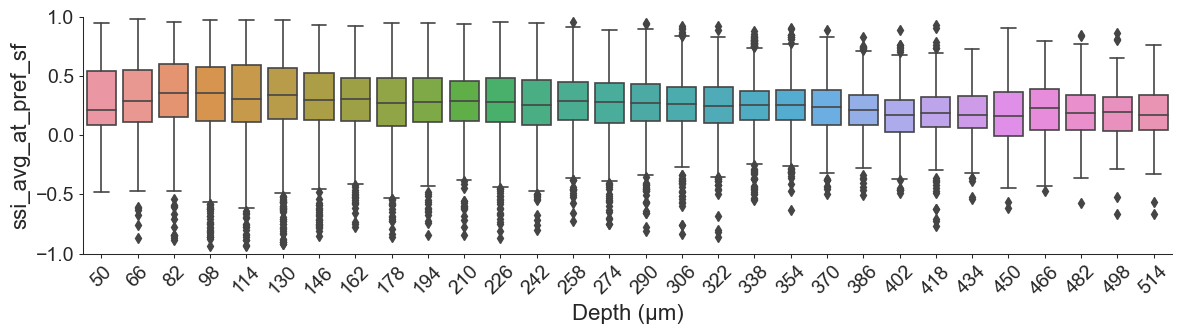

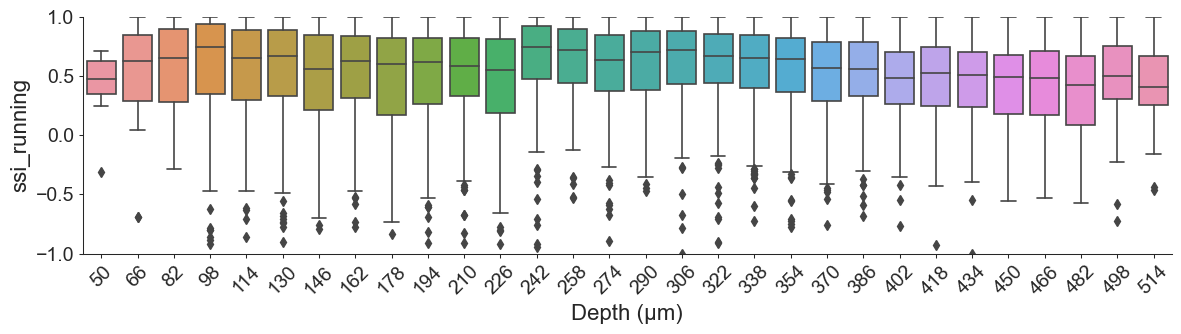

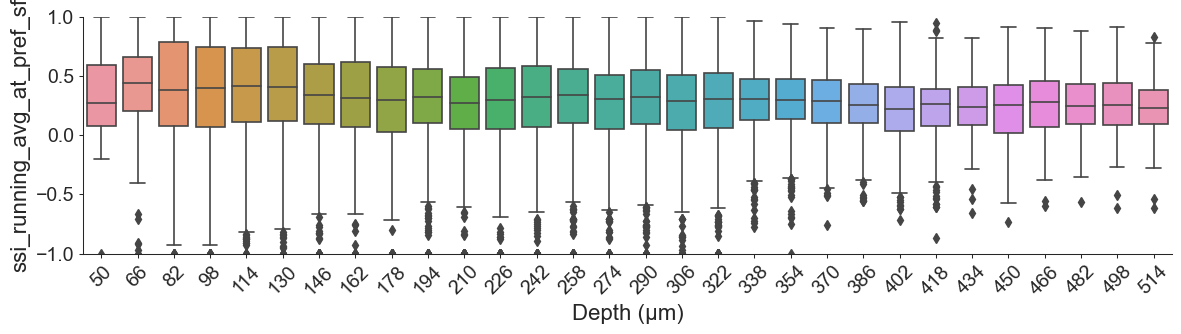

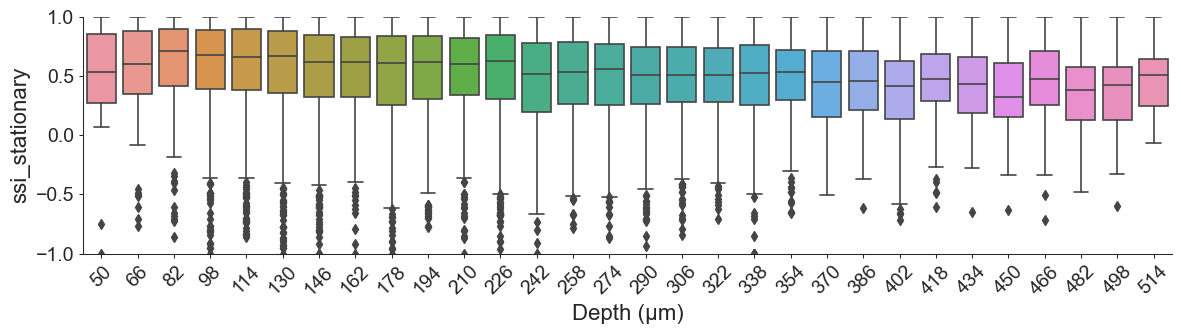

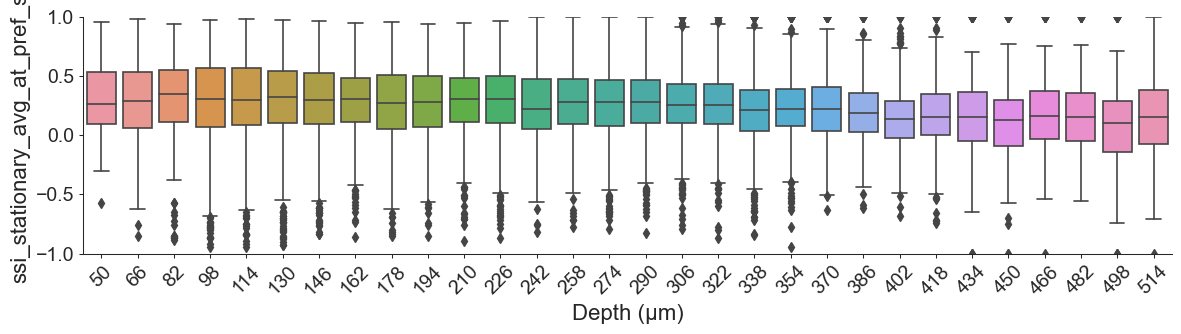

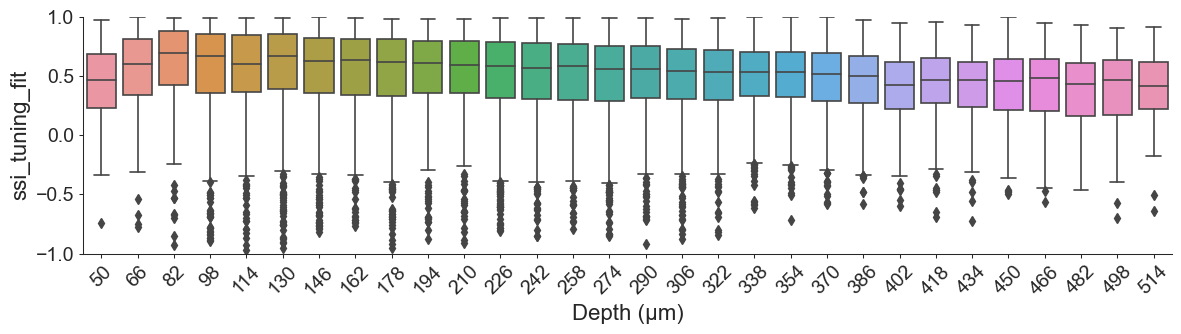

In [23]:
for ssi in ssi_keys:
    fig, ax = plt.subplots(figsize=(12, 3.5))

    # sns.boxplot(data=metrics, y="depth", x=ssi, orient="h", ax=ax)
    sns.boxplot(data=ssi_metrics, x="depth", y=ssi, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel("SSI" if ssi == "ssi" else ssi, fontsize=16)
    ax.set_xlabel("Depth (µm)", fontsize=16)
    ax.set_xticklabels([int(float(s.get_text())) for s in ax.get_xticklabels()], rotation=45)
    ax.tick_params(labelsize=14)
    ax.set_ylim(-1, 1)
    fig.tight_layout()
    fig.savefig(f"/Users/chase/Library/CloudStorage/OneDrive-AllenInstitute/Surround Models/ssi_plots_all_mice/{ssi}.png", dpi=150)


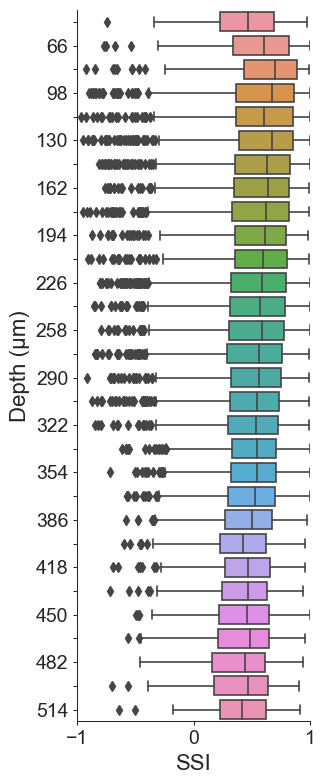

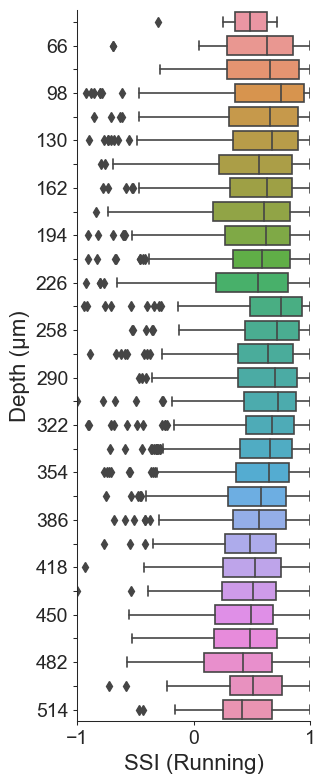

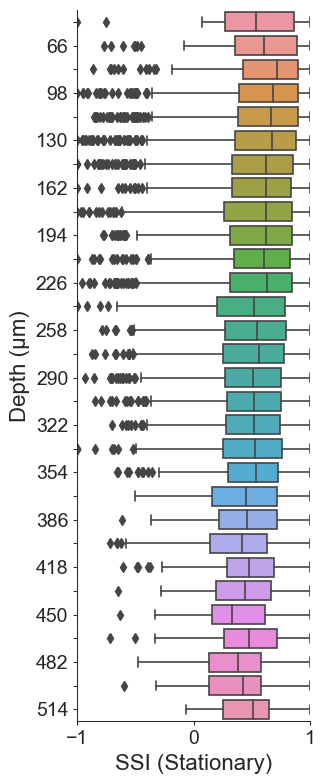

In [24]:
# Plot vertically SSI
for met, label in (("ssi_tuning_fit", "SSI"), ("ssi_running", "SSI (Running)"), ("ssi_stationary", "SSI (Stationary)")):
    fig, ax = plt.subplots(figsize=(3.5, 8))
    sns.boxplot(data=ssi_metrics, y="depth", x=met, orient="h", ax=ax)
    ax.set_xlabel(label, fontsize=16)
    ax.set_ylabel("Depth (µm)", fontsize=16)
    ax.set_yticklabels([int(float(s.get_text())) if i % 2 == 1 else "" for i, s in enumerate(ax.get_yticklabels())])
    ax.tick_params(labelsize=14)
    ax.set_xlim(-1, 1)
    fig.tight_layout()
    fig.savefig(f"/Users/chase/Desktop/{met}.png", dpi=150)

In [25]:
quantile_df = ssi_metrics.groupby("depth")[["ssi", "ssi_running", "ssi_stationary"]].quantile([0.25, 0.5, 0.75])
quantile_df.index.set_names(["depth", "quantile"], inplace=True)
quantile_df = quantile_df.reorder_levels(["quantile", "depth"]).sort_index()
quantile_df

ssi  ssi_running  ssi_stationary
quantile depth                                       
0.25     50.0   0.319716     0.350955        0.270648
         66.0   0.383377     0.286651        0.349451
         82.0   0.428325     0.284402        0.417549
         98.0   0.436956     0.351720        0.389587
         114.0  0.367317     0.301532        0.382687
...                  ...          ...             ...
0.75     450.0  0.650042     0.682891        0.609895
         466.0  0.694347     0.710627        0.714267
         482.0  0.660633     0.673116        0.579134
         498.0  0.696946     0.752425        0.576492
         514.0  0.664233     0.667868        0.644618

[90 rows x 3 columns]

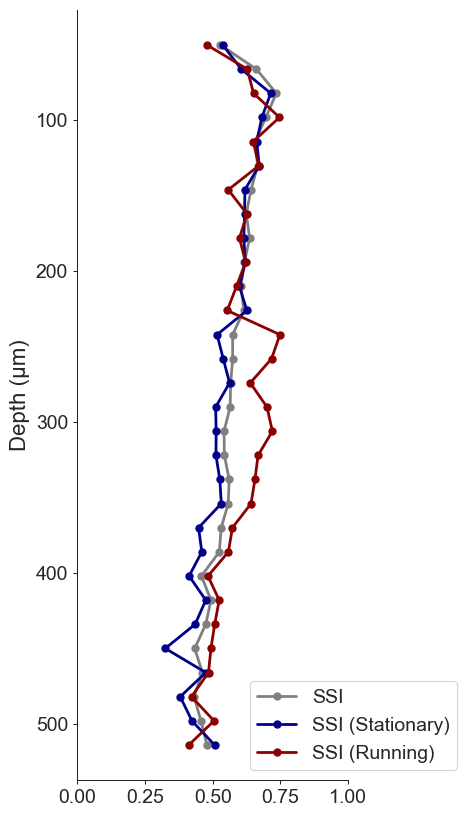

In [26]:
# Plot stationary and running on same axes
fig, ax = plt.subplots(figsize=(3.5, 10))

for metric_name, metric, color in (("SSI", "ssi", "gray"), ("SSI (Stationary)", "ssi_stationary", "darkblue"), ("SSI (Running)", "ssi_running", "darkred")):
    median = quantile_df[metric][0.5]
    err_low = quantile_df[metric][0.25]
    err_high = quantile_df[metric][0.75]
    depth = median.index
    ax.plot(median, depth, color=color, linewidth=2, marker=".", markersize=10, label=metric_name)
    # ax.fill_betweenx(y=depth, x1=err_low, x2=err_high, color=color, alpha=0.1)
    # ax.errorbar(median, depth, xerr=np.vstack((err_low, err_high)), color=color, linewidth=2, marker=".", markersize=10)

# ax.set_xlabel(label, fontsize=16)
ax.set_ylabel("Depth (µm)", fontsize=16)
# ax.set_yticklabels([int(float(s.get_text())) if i % 2 == 1 else "" for i, s in enumerate(ax.get_yticklabels())])
ax.tick_params(labelsize=14)
ax.set_xlim(0, 1)
ax.invert_yaxis()
ax.legend(fontsize=14, bbox_to_anchor=(0.6,0), loc="lower left", bbox_transform=ax.transAxes)
# fig.tight_layout()
fig.savefig(f"/Users/chase/Desktop/ssi_run_stat.png", dpi=150, bbox_inches="tight")

In [27]:
depth_arr = []
run_corr_arr = []

for group in iter_plane_groups():
    depth = group.attrs["plane_depth_microns"]
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    for roi in np.where(inclusion)[0]:
        depth_arr.append(depth)
        run_corr_arr.append(group["running_correlations"][roi])

run_corr_df = pd.DataFrame(data=dict(depth=depth_arr, run_corr=run_corr_arr))
run_corr_df

,depth,run_corr
0,50,-0.016212
1,50,0.043872
2,50,-0.007672
3,50,-0.010710
4,66,0.019992
...,...,...
63471,514,0.015814
63472,514,0.006684
63473,514,-0.001346
63474,514,-0.003532


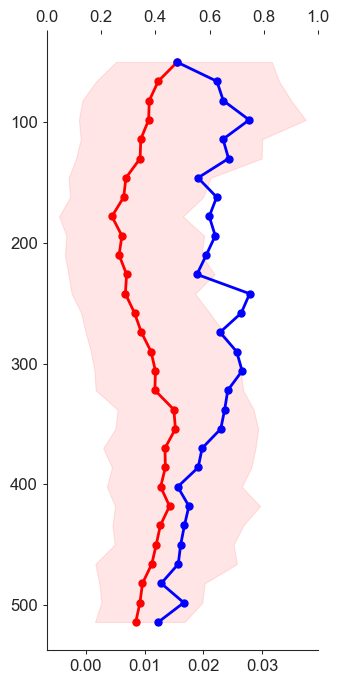

In [28]:
fig, ax = plt.subplots(figsize=(3.5, 8))

median = quantile_df["ssi_running"][0.5]
depth = median.index
ax2 = ax.twiny()
ax2.plot(median, depth, color="blue", linewidth=2, marker=".", markersize=10, label="SSI")
ax2.set_xlim(0, 1)

median = run_corr_df.groupby("depth")["run_corr"].quantile(0.5)
depth = median.index
ax.plot(median, depth, color="red", linewidth=2, marker=".", markersize=10, label="Run Corr")
err_low = run_corr_df.groupby("depth")["run_corr"].quantile(0.25)
err_high = run_corr_df.groupby("depth")["run_corr"].quantile(0.75)
ax.fill_betweenx(y=depth, x1=err_low, x2=err_high, color="red", alpha=0.1)

ax.invert_yaxis()

In [29]:
# Test correlation between ssi_running and running_correlation
ssi_running = []
running_correlation = []

for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()] & group["drifting_gratings_windowed"]["is_responsive"][()]
    ssi_running.extend(group["ssi"]["ssi_running"][inclusion])
    running_correlation.extend(group["running_correlations"][inclusion])

ssi_running = np.array(ssi_running)
running_correlation = np.array(running_correlation)
mask = ~np.isnan(ssi_running) & ~np.isnan(running_correlation)
scipy.stats.pearsonr(ssi_running[mask], running_correlation[mask])

PearsonRResult(statistic=0.040009334255806585, pvalue=0.002656079016525704)

# Look at mean DGW and DGF response

In [30]:
relative_dir = np.array([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
relative_dir_idx = np.arange(13) - 6

dgw_resp = []
dgf_resp = []

for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()] & group["drifting_gratings_windowed"]["is_responsive"][()]# & group["drifting_gratings_full"]["is_responsive"][()]
    
    for dg_type, resp_list in (("windowed", dgw_resp), ("full", dgf_resp)):
        dg = group[f"drifting_gratings_{dg_type}"]
        trial_responses = dg["trial_responses"][inclusion]
        mean_cond_responses = np.nanmean(trial_responses, axis=-1)
        pref_cond_index = dg["pref_cond_index"][inclusion]

        for i in range(len(trial_responses)):
            pref_dir_idx, pref_sf_idx = pref_cond_index[i]
            dir_mean_resp = mean_cond_responses[i, :, pref_sf_idx]
            rel_idx = (relative_dir_idx + pref_dir_idx) % 12
            resp_list.append(dir_mean_resp[rel_idx])

dgw_resp = np.vstack(dgw_resp)
dgf_resp = np.vstack(dgf_resp)

print(f"DGW {len(dgw_resp)}")
print(f"DGF {len(dgf_resp)}")

DGW 17816
DGF 17816


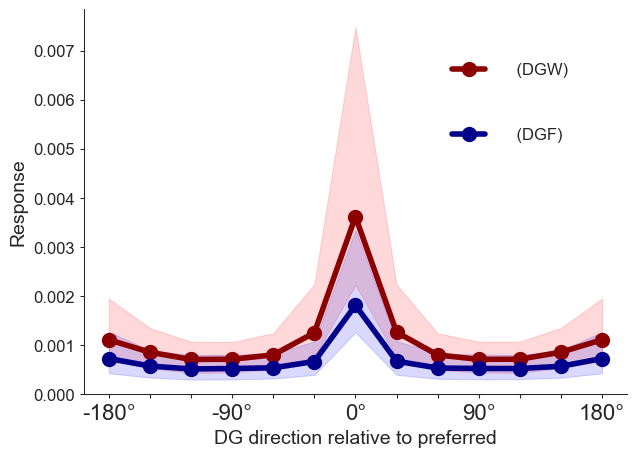

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))

for label, resp_list, color in (("DGW", dgw_resp, "red"), ("DGF", dgf_resp, "blue")):
    err_low, med, err_high = np.quantile(resp_list, [0.25, 0.5, 0.75], axis=0)
    ax.plot(relative_dir, med, linewidth=4, color=f"dark{color}", marker="o", markersize=10, label=f"    ({label})")
    ax.fill_between(x=relative_dir, y1=err_low, y2=err_high, color=color, alpha=0.15)

ax.set_xticks(relative_dir, labels=[f"{d}°" if d % 90 == 0 else "" for d in relative_dir], fontsize=16)
ax.set_xlabel("DG direction relative to preferred")
ax.set_ylabel("Response")
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend(loc="upper left", frameon=False, labelspacing=3, bbox_to_anchor=(0.65, 0.9), bbox_transform=ax.transAxes)
fig.savefig("/Users/chase/Desktop/dg_dir_resp.png", dpi=250, bbox_inches="tight")

# LSN/receptive field analysis

In [32]:
lsn_metrics = []

for group in iter_plane_groups():
    lsn = group["locally_sparse_noise"]
    session_id = group.attrs["session_id"]
    volume = group.attrs["volume"]
    plane = group.attrs["plane"]
    depth = group.attrs["plane_depth_microns"]

    for roi in np.where(group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()])[0]:
        row = {}
        lsn_metrics.append(row)

        row["roi"] = f"{session_id}_{plane}_{roi}"
        row["mouse"] = group.attrs["mouse"]
        row["column"] = group.attrs["column"]
        row["volume"] = volume
        row["plane"] = plane
        row["is_responsive"] = lsn["is_responsive"][roi, 2]

        for rf_type_idx, rf_type in enumerate(("on", "off")):
            has_onoff_rf = lsn["is_responsive"][roi, rf_type_idx]
            row[f"has_rf_{rf_type}"] = has_onoff_rf
            
            if has_onoff_rf:
                azi, alt = lsn["rf_centers"][roi, rf_type_idx]
                row[f"rf_{rf_type}_alt_deg"] = alt
                row[f"rf_{rf_type}_azi_deg"] = azi
    
        # Save ROI centroid
        y, x = group["roi_centroids"][roi]
        row["roi_centroid_x_px"] = x
        row["roi_centroid_y_px"] = y
        row["depth_microns"] = depth

lsn_metrics = pd.DataFrame(lsn_metrics)
lsn_metrics.set_index("roi", inplace=True)
lsn_metrics["rf_on_dist_to_origin_deg"] = np.sqrt(lsn_metrics.rf_on_alt_deg**2 + lsn_metrics.rf_on_azi_deg**2)
lsn_metrics["rf_off_dist_to_origin_deg"] = np.sqrt(lsn_metrics.rf_off_alt_deg**2 + lsn_metrics.rf_off_azi_deg**2)
lsn_metrics["rf_on_off_dist_deg"] = np.sqrt((lsn_metrics.rf_on_alt_deg - lsn_metrics.rf_off_alt_deg)**2 + (lsn_metrics.rf_on_azi_deg - lsn_metrics.rf_off_azi_deg)**2)

print(f"LSN responsive rate: {lsn_metrics.is_responsive.sum()} / {len(lsn_metrics)} ({lsn_metrics.is_responsive.mean()*100:.1f}%)")

lsn_metrics

LSN responsive rate: 17003 / 63476 (26.8%)


,mouse,column,volume,plane,is_responsive,has_rf_on,has_rf_off,roi_centroid_x_px,roi_centroid_y_px,depth_microns,rf_on_alt_deg,rf_on_azi_deg,rf_off_alt_deg,rf_off_azi_deg,rf_on_dist_to_origin_deg,rf_off_dist_to_origin_deg,rf_on_off_dist_deg
roi,,,,,,,,,,,,,,,,,
M409828_21_0_0,409828,2,1,0,False,False,False,113.634409,267.774194,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M409828_21_0_1,409828,2,1,0,False,False,False,206.227979,290.683938,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M409828_21_0_4,409828,2,1,0,False,False,False,160.754386,341.274854,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M409828_21_0_149,409828,2,1,0,False,False,False,342.841629,457.683258,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M409828_21_1_0,409828,2,1,1,False,False,False,103.308869,438.119266,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M438833_55_5_195,438833,5,5,5,False,False,False,300.778261,254.869565,514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M438833_55_5_212,438833,5,5,5,False,False,False,410.627907,99.837209,514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M438833_55_5_218,438833,5,5,5,False,False,False,452.304348,91.074534,514,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[0.0, 0.6, 0.0, 0.6, 0.0, 0.6]

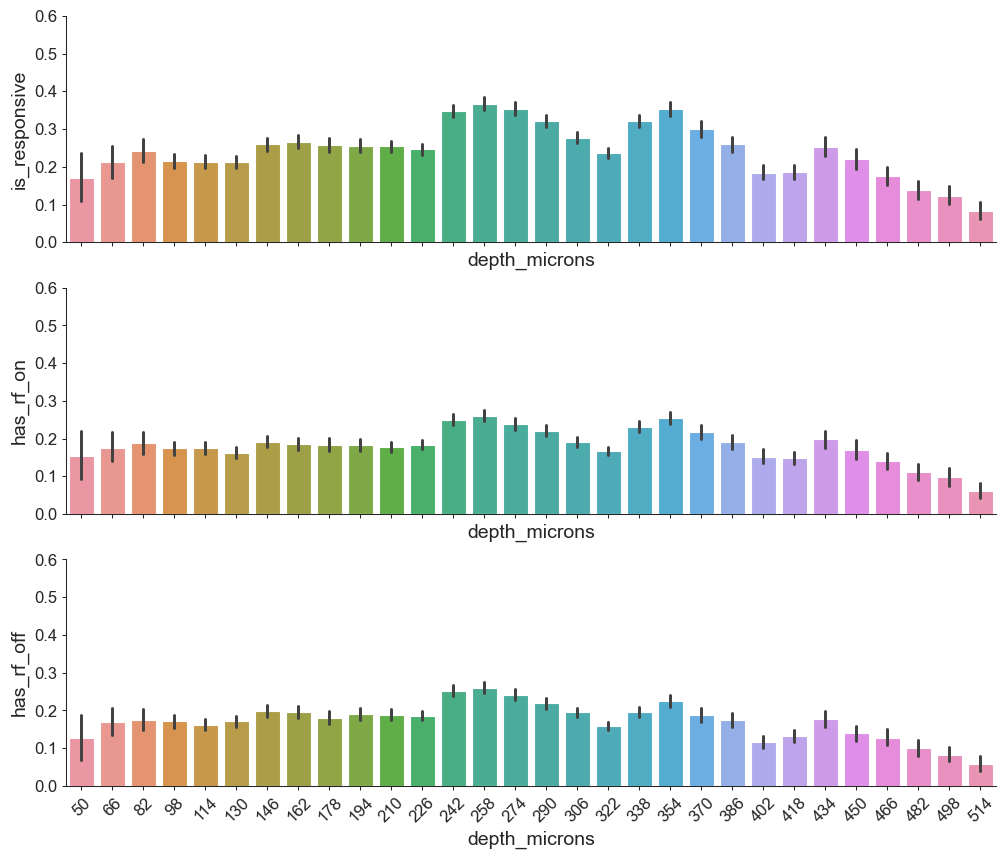

In [33]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3, sharex=True)
sns.barplot(data=lsn_metrics, x="depth_microns", y="is_responsive", ax=axs[0])
sns.barplot(data=lsn_metrics, x="depth_microns", y="has_rf_on", ax=axs[1])
sns.barplot(data=lsn_metrics, x="depth_microns", y="has_rf_off", ax=axs[2])
plt.setp((ax.get_xticklabels() for ax in axs), rotation=45)
plt.setp(axs, ylim=(0, 0.6))

Volume 1: 0.17178148478288552 0.16796128867948554 0.12441105310072584
Volume 2: 0.18413356080916402 0.18961735315622716 0.11832805264440653
Volume 3: 0.21792543021032504 0.21754302103250478 0.12332695984703633
Volume 4: 0.2071494042163153 0.17850595783684692 0.1051023525817293
Volume 5: 0.13848817080207732 0.12156183881515677 0.08366993652625505


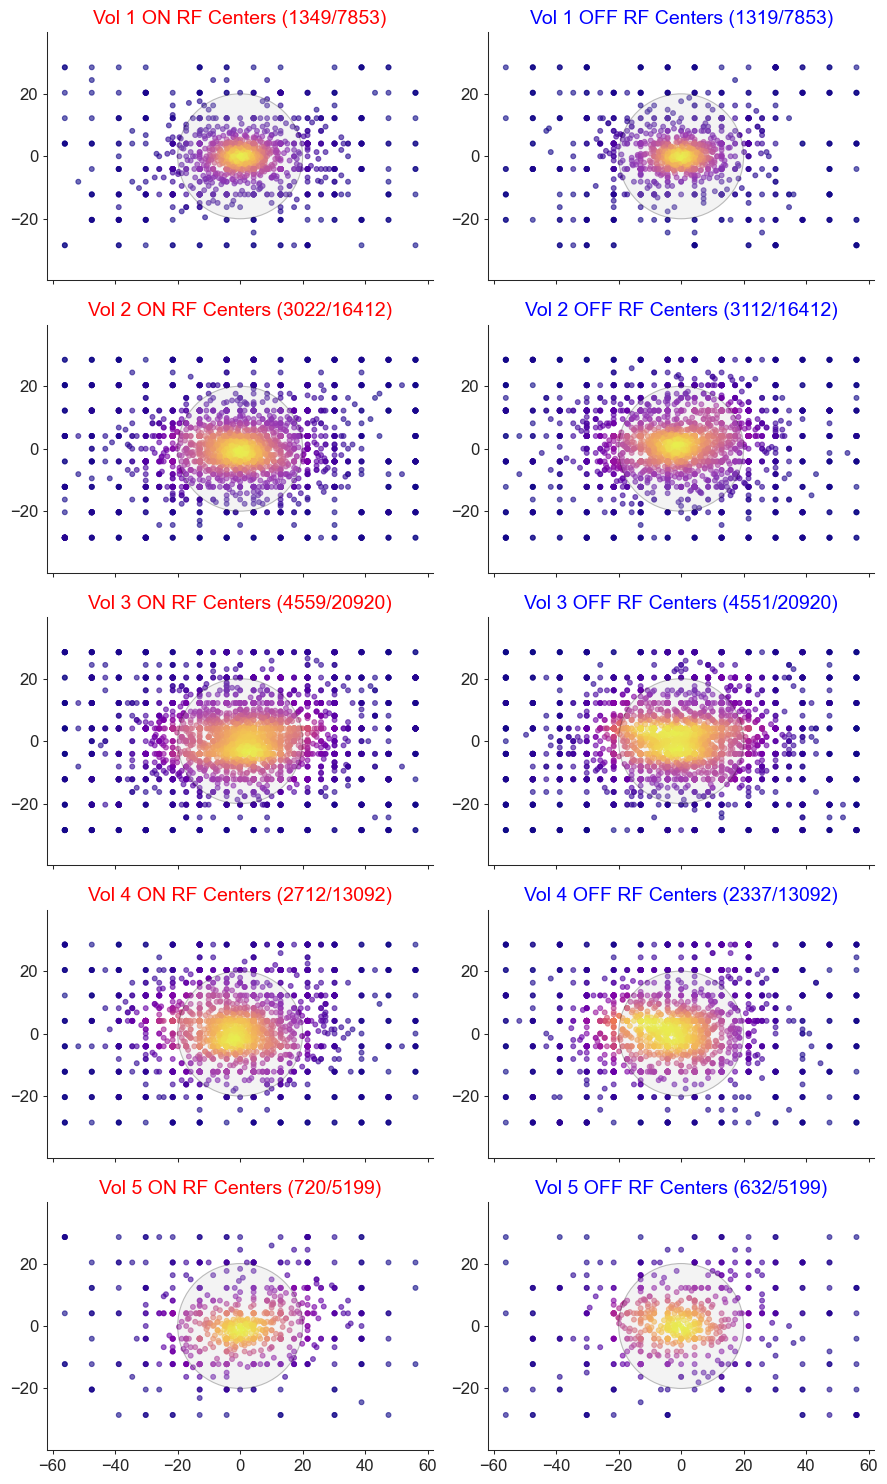

In [34]:
volumes = lsn_metrics.volume.unique()
volumes = [v for v in volumes if v in range(1, 7)] # Only volumes 1-6
r = 20

fig, axs = plt.subplots(figsize=(9, 3*len(volumes)), nrows=len(volumes), ncols=2, sharex=True)

for row_i, volume in enumerate(volumes):
    vol_met = lsn_metrics[lsn_metrics.volume == volume]

    # (vol_met.rf_on_dist_to_origin_deg[vol_met.has_rf_on] <= r).mean()*100
    axs[row_i, 0].set_title(f"Vol {volume} ON RF Centers ({vol_met.has_rf_on.sum()}/{len(vol_met)})", color="red")
    at.density_scatter(vol_met.rf_on_azi_deg[vol_met.has_rf_on], vol_met.rf_on_alt_deg[vol_met.has_rf_on], ax=axs[row_i, 0])
    axs[row_i, 0].axis("equal")

    # (vol_met.rf_on_dist_to_origin_deg[vol_met.has_rf_off] <= r).mean()*100
    axs[row_i, 1].set_title(f"Vol {volume} OFF RF Centers ({vol_met.has_rf_off.sum()}/{len(vol_met)})", color="blue")
    at.density_scatter(vol_met.rf_off_azi_deg[vol_met.has_rf_off], vol_met.rf_off_alt_deg[vol_met.has_rf_off], ax=axs[row_i, 1])
    axs[row_i, 1].axis("equal")

    print(f"Volume {volume}:", vol_met.has_rf_on.mean(), vol_met.has_rf_off.mean(), (vol_met.has_rf_on & vol_met.has_rf_off).mean())

for ax in axs.flat:
    ax.add_patch(plt.Circle((0, 0), r, edgecolor="black", facecolor="lightgray", alpha=0.25))

fig.tight_layout()


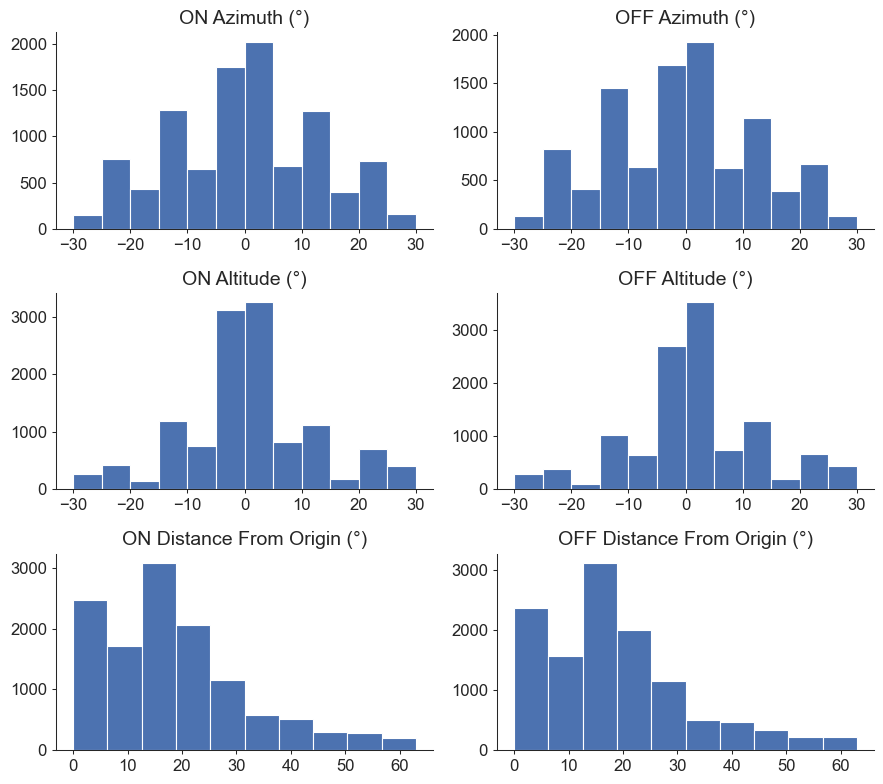

In [35]:
fig, axs = plt.subplots(figsize=(9, 8), nrows=3, ncols=2)
axs[0, 0].hist(lsn_metrics.rf_on_azi_deg[lsn_metrics.has_rf_on], bins=np.arange(-30, 35, 5))
axs[0, 0].set_title("ON Azimuth (°)")
axs[0, 1].hist(lsn_metrics.rf_off_azi_deg[lsn_metrics.has_rf_off], bins=np.arange(-30, 35, 5))
axs[0, 1].set_title("OFF Azimuth (°)")

axs[1, 0].hist(lsn_metrics.rf_on_alt_deg[lsn_metrics.has_rf_on], bins=np.arange(-30, 35, 5))
axs[1, 0].set_title("ON Altitude (°)")
axs[1, 1].hist(lsn_metrics.rf_off_alt_deg[lsn_metrics.has_rf_off], bins=np.arange(-30, 35, 5))
axs[1, 1].set_title("OFF Altitude (°)")

axs[2, 0].hist(lsn_metrics.rf_on_dist_to_origin_deg[lsn_metrics.has_rf_on])
axs[2, 0].set_title("ON Distance From Origin (°)")
axs[2, 1].hist(lsn_metrics.rf_off_dist_to_origin_deg[lsn_metrics.has_rf_off])
axs[2, 1].set_title("OFF Distance From Origin (°)")

fig.tight_layout()

# Population retinotopy

In [36]:
# Transformation

# (row, col), in pixels, column center before tranformation
COLUMN_CENTERS = {
    1: (0, 0),
    2: (-256, -256),
    3: (256, -256),
    4: (-256, 256),
    5: (256, 256)
}

COLUMN_COLORS = {
    1: 'r',
    2: 'g',
    3: 'b',
    4: 'm',
    5: 'k'
}

PIXEL_CENTER = 255.5 # Row and col go from 0 to 511 (inclusive), so the center is at 255.5
PIXEL_TO_MICRONS = 0.78125 # 400 microns / 512 pixels
TRANSFORM_MATRIX = scipy.spatial.transform.Rotation.from_euler("z", -40, degrees=True).as_matrix()[:2, :2] * PIXEL_TO_MICRONS

def column_center_pixels(pixel_points, column):
    pixel_points = np.array(pixel_points)
    orig_shape = pixel_points.shape
    pixel_points = np.atleast_2d(pixel_points)
    bias = COLUMN_CENTERS[column]
    pixel_points[:, 0] = -(pixel_points[:, 0] - PIXEL_CENTER) + bias[0] # Note: the row is subtracted here
    # roi_row_col_centered[:, 0] = roi_row_col_centered[:, 0] - PIXEL_CENTER + bias[0] # Note: the row is subtracted here
    pixel_points[:, 1] = pixel_points[:, 1] - PIXEL_CENTER + bias[1]
    return pixel_points.reshape(orig_shape)

def transform_pixels_to_microns(pixel_points, column=None):
    if column is not None:
        pixel_points = column_center_pixels(pixel_points, column)
    
    return np.matmul(pixel_points, TRANSFORM_MATRIX)

In [37]:
rf_type, rf_type_idx = "ON", 0
# rf_type, rf_type_idx = "OFF", 1

rf_df = pd.DataFrame(columns=["mouse", "column", "roi_position_px", "rf_azi_deg", "rf_alt_deg"])

at.set_included_columns() # All columns

for group in iter_plane_groups():
    mouse = group.attrs["mouse"]
    column = group.attrs["column"]
    depth = group.attrs["plane_depth_microns"]
    lsn = group["locally_sparse_noise"]

    inclusion = group["is_roi_valid"][()] & lsn["is_responsive"][:, rf_type_idx]

    for roi in np.where(inclusion)[0]:
        azi, alt = lsn["rf_centers"][roi, rf_type_idx]
        roi_position_px = group["roi_centroids"][roi]

        rf_df.loc[len(rf_df)] = (mouse, column, roi_position_px, azi, alt)

rf_df

,mouse,column,roi_position_px,rf_azi_deg,rf_alt_deg
0,409828,1,"[257.625, 496.67788461538464]",-21.589286,-28.481250
1,409828,1,"[262.0169491525424, 496.2401129943503]",-0.301246,0.283866
2,409828,1,"[177.34193548387097, 316.33870967741933]",-8.741028,-0.099238
3,409828,1,"[186.16, 152.17818181818183]",-3.418304,1.525781
4,409828,1,"[31.059113300492612, 348.6256157635468]",4.317857,4.068750
...,...,...,...,...,...
35034,438833,5,"[317.2782608695652, 506.4173913043478]",11.719898,7.556250
35035,438833,5,"[91.25196850393701, 276.0551181102362]",38.860714,28.481250
35036,438833,5,"[87.6441717791411, 255.98159509202455]",38.860714,4.068750
35037,438833,5,"[34.08860759493671, 440.32911392405066]",10.075000,-1.356250


In [ ]:
rf_df["roi_position_px_centered"] = rf_df.apply(lambda row: column_center_pixels(row["roi_position_px"], row["column"]), axis=1)
rf_df["roi_position_microns"] = list(transform_pixels_to_microns(np.vstack(rf_df["roi_position_px_centered"])))

rf_df

,mouse,column,roi_position_px,rf_azi_deg,rf_alt_deg,roi_position_px_centered,roi_position_microns
0,409828,1,"[257.625, 496.67788461538464]",-21.589286,-28.481250,"[-2.125, 241.17788461538464]","[-122.38593781469291, 143.2711364392356]"
1,409828,1,"[262.0169491525424, 496.2401129943503]",-0.301246,0.283866,"[-6.516949152542395, 240.74011299435028]","[-124.79455818101552, 140.80360283355117]"
2,409828,1,"[177.34193548387097, 316.33870967741933]",-8.741028,-0.099238,"[78.15806451612903, 60.83870967741933]","[16.223579873088685, 75.65952417419123]"
3,409828,1,"[186.16, 152.17818181818183]",-3.418304,1.525781,"[69.34, -103.32181818181817]","[93.38398923705319, -27.014227980833255]"
4,409828,1,"[31.059113300492612, 348.6256157635468]",4.317857,4.068750,"[224.4408866995074, 93.12561576354682]","[87.55601727157534, 168.442329332189]"
...,...,...,...,...,...,...,...
35034,438833,5,"[317.2782608695652, 506.4173913043478]",11.719898,7.556250,"[194.2217391304348, 506.9173913043478]","[-138.32635489944101, 400.90982669834295]"
35035,438833,5,"[91.25196850393701, 276.0551181102362]",38.860714,28.481250,"[420.248031496063, 276.5551181102362]","[112.62692651764925, 376.5497961603804]"
35036,438833,5,"[87.6441717791411, 255.98159509202455]",38.860714,4.068750,"[423.8558282208589, 256.4815950920246]","[124.86657066749044, 366.348105747134]"
35037,438833,5,"[34.08860759493671, 440.32911392405066]",10.075000,-1.356250,"[477.4113924050633, 440.82911392405066]","[64.34285297977888, 503.5693912873086]"


(-598.0095048952712, 611.203816532716, -608.861925793575, 606.5393699020427)

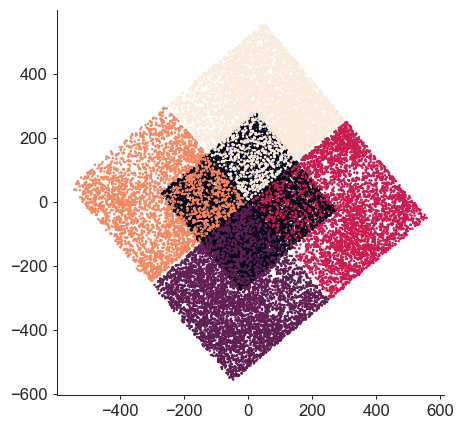

In [ ]:
pos = np.vstack(rf_df.roi_position_microns.values)
plt.figure(figsize=(5, 5))
plt.scatter(pos[:, 0], pos[:, 1], c=rf_df.column, s=1)
plt.axis("equal")

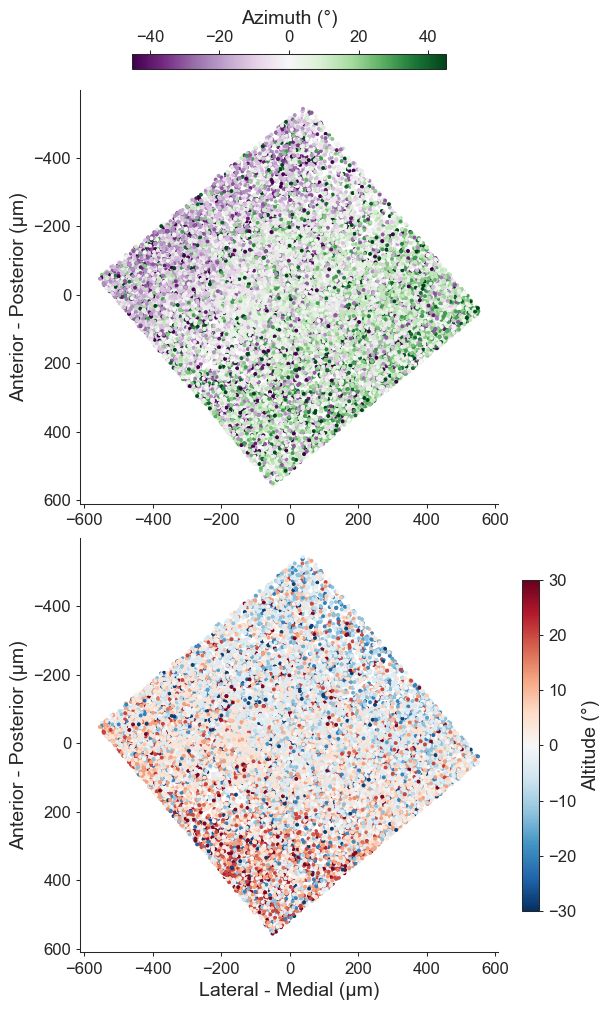

In [ ]:
fig, axs = plt.subplots(figsize=(6, 10), nrows=2, layout="constrained")
pos = np.vstack(rf_df.roi_position_microns.values)
# pos = np.vstack(rf_df.roi_position_px_centered.values)

# Azimuth
r = 45
cmap = "PRGn"
# cmap = "viridis"
ax = axs[0]
sc = ax.scatter(pos[:, 1], pos[:, 0], s=4, c=rf_df.rf_azi_deg, cmap=cmap, vmin=-r, vmax=r)
fig.colorbar(sc, ax=ax, label="Azimuth (°)", location="top", shrink=0.75)

# Altitude
r = 30
cmap = "RdBu_r"
# cmap = "plasma"
ax = axs[1]
sc = ax.scatter(pos[:, 1], pos[:, 0], s=4, c=rf_df.rf_alt_deg, cmap=cmap, vmin=-r, vmax=r)
# sc = ax.scatter(pos[:, 1], pos[:, 0], s=4, c=rf_df.rf_alt_deg > 0)
fig.colorbar(sc, ax=ax, label="Altitude (°)", shrink=0.8)


# # # axs[0].add_patch(plt.Rectangle((-512, 0), 512, 512, alpha=0.25))
axs[1].set_xlabel("Lateral - Medial (µm)")
for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel("Anterior - Posterior (µm)")
    ax.axis("equal")

# fig.tight_layout()

# Plot DG tuning and RF metrics

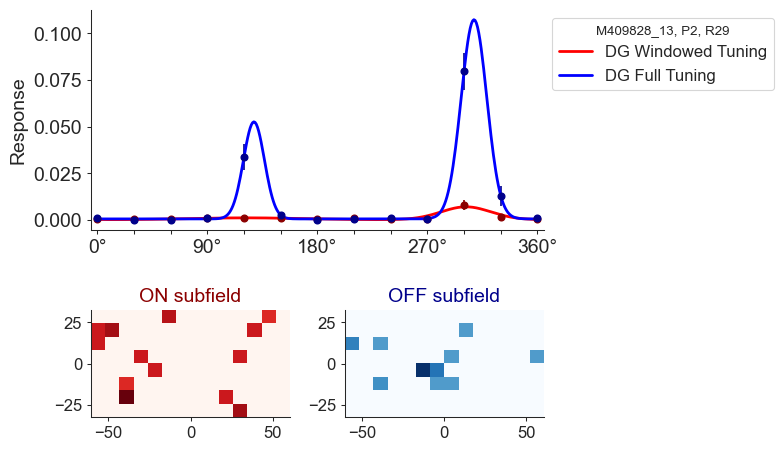

In [ ]:
from allen_v1dd.stimulus_analysis.drifting_gratings import load_dg_xarray_from_h5
from allen_v1dd.stimulus_analysis.locally_sparse_noise import get_imshow_extent
from allen_v1dd.stimulus_analysis.fit_utils import vonmises_two_peak

# Insert your ROI here
## roi_index = "M409828_13_1_26"
# roi_index = "M409828_13_4_19"
roi_index = "M409828_13_2_29" # SF
# roi_index = "M409828_13_2_158"
# roi_index = "M409828_13_2_83"

session_id, plane, roi = roi_index.rsplit("_", maxsplit=2)
plane = int(plane)
roi = int(roi)
mouse = roi_index.split("_", maxsplit=1)[0]

for group in iter_plane_groups():
    if group.attrs["session_id"] != session_id or group.attrs["plane"] != plane: continue
    
    fig = plt.figure(figsize=(8, 5), tight_layout=True)
    gs = mpl.gridspec.GridSpec(2, 2)

    # DG tuning
    ax = fig.add_subplot(gs[0, :])
    for dg_type, fit_color, resp_color in zip(("windowed", "full"), ("red", "blue"), ("darkred", "darkblue")):
        dg = group[f"drifting_gratings_{dg_type}"]
        pref_dir_idx, pref_sf_idx = dg["pref_cond_index"][roi]
        trial_responses = load_dg_xarray_from_h5(dg, "trial_responses").sel(roi=roi).isel(spatial_frequency=pref_sf_idx)
        
        # Plot ROI repsonses
        direction = np.array(list(trial_responses.direction.values) + [360])
        mean_resp = [trial_responses.sel(direction=d).mean("trial", skipna=True).item() for d in direction % 360]
        mean_resp_err = [trial_responses.sel(direction=d).std("trial", skipna=True).item() / np.sqrt(trial_responses.sel(direction=d).count("trial")) for d in direction % 360]
        ax.errorbar(direction, mean_resp, yerr=mean_resp_err, fmt="o", color=resp_color)
        ax.set_xticks(direction, labels=[f"{d}°" if i % 3 == 0 else "" for i, d in enumerate(direction)])
        ax.tick_params(labelsize=14)
        ax.set_xlim(-5, 365)
        ax.set_ylabel("Response", fontsize=14)

        # Tuning curve fit
        fit_params = dg["tuning_curve_params"][roi, pref_sf_idx]
        fit_x = np.arange(0, 361)
        fit_y = vonmises_two_peak(fit_x, *fit_params)
        ax.plot(fit_x, fit_y, color=fit_color, linewidth=2, linestyle="solid", label=f"DG {dg_type.capitalize()} Tuning")

        ax.legend(loc="upper left", bbox_transform=ax.transAxes, bbox_to_anchor=(1, 1), title=f"{session_id}, P{plane}, R{roi}")


    # LSN
    lsn = group["locally_sparse_noise"]
    imshow_extent = get_imshow_extent(azimuths=lsn.attrs["azimuths"], altitudes=lsn.attrs["altitudes"])
    ax = fig.add_subplot(gs[1, 0])
    ax.imshow(lsn["receptive_fields"][roi, 0], extent=imshow_extent, cmap="Reds")
    ax.set_title("ON subfield", color="darkred")
    ax = fig.add_subplot(gs[1, 1])
    ax.imshow(lsn["receptive_fields"][roi, 1], extent=imshow_extent, cmap="Blues")
    ax.set_title("OFF subfield", color="darkblue")